In [1]:
pip install pykalman


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 3.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [88]:
df=pd.read_csv('drive/MyDrive/lab4/Vietcombank.csv')
df
df1=df.reset_index()['Close']

In [89]:
df

,Date,Open,High,Low,Close,Volume
0,2019-03-01 00:00:00+07:00,40478.95313,41275.25781,40346.23438,41275.25781,1225908
1,2019-03-04 00:00:00+07:00,41275.25781,41806.13281,41275.25781,41673.41406,2030592
2,2019-03-05 00:00:00+07:00,41673.41406,42337.00391,41474.33594,41806.13281,2376092
3,2019-03-06 00:00:00+07:00,41872.48828,42005.20703,41076.18359,41607.05469,2107101
4,2019-03-07 00:00:00+07:00,41607.05469,42337.00391,41540.69531,41872.48828,3091640
...,...,...,...,...,...,...
1301,2024-05-27 00:00:00+07:00,90400.00000,90600.00000,89700.00000,90200.00000,1258620
1302,2024-05-28 00:00:00+07:00,89800.00000,90700.00000,89800.00000,90700.00000,1814349
1303,2024-05-29 00:00:00+07:00,90800.00000,91000.00000,89800.00000,89800.00000,1186438
1304,2024-05-30 00:00:00+07:00,89500.00000,89700.00000,88500.00000,88600.00000,2400732


In [90]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [91]:
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [92]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [93]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest= create_dataset(test_data, time_step)

In [94]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)



(943, 100)
(943,)
(161, 100)
(161,)


In [95]:
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=X_train[0][0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

In [96]:
kf = kf.em(X_train[0])

In [97]:
test_data.shape

(262, 1)

In [98]:
test_observed = test_data
test_predicted, _ = kf.filter(test_observed)


In [99]:
test_predicted.shape

(262, 1)

In [100]:
test_predicted=scaler.inverse_transform(test_predicted)
ytest=ytest.reshape(-1,1)
ytest=scaler.inverse_transform(test_data)

In [101]:
test_rmse = np.sqrt(np.mean((test_predicted - ytest)**2))
test_mae = mean_absolute_error(test_predicted, ytest)
test_mape = np.mean(np.abs(test_predicted - ytest)/np.abs(test_predicted))*100

In [102]:
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1639.7843415993968
Testing MAPE: 0.5358117470453123
Testing MAE: 396.68199083683555


In [103]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape[1]

202

In [104]:
test_data[60:].shape

(202, 1)

In [105]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<90):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        #print(x_input)
        yhat, _ = kf.filter(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat[-1].tolist())
        i=i+1
    else:
        x_input = x_input.reshape(n_steps)
        yhat, _ = kf.filter(x_input)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat[-1].tolist())
        i=i+1

Streaming output truncated to the last 5000 lines.
 [0.30205281]
 [0.30589816]
 [0.30422085]
 [0.30370712]
 [0.30604795]
 [0.30319608]
 [0.29982444]
 [0.29843489]
 [0.29444048]
 [0.30142537]
 [0.30356469]
 [0.29601163]
 [0.29655334]
 [0.29743302]
 [0.29591804]
 [0.29188521]
 [0.28993628]
 [0.28933936]
 [0.28273266]
 [0.2839211 ]
 [0.28143004]
 [0.28602031]
 [0.28885374]
 [0.28793715]
 [0.28979772]
 [0.28858316]
 [0.2874974 ]
 [0.28716485]
 [0.28206665]
 [0.28157582]
 [0.28035485]
 [0.28533412]
 [0.2861454 ]
 [0.28175442]
 [0.28219396]
 [0.28554052]
 [0.28977744]
 [0.29464394]
 [0.30041703]
 [0.30182833]
 [0.30440187]
 [0.30090751]
 [0.30411985]
 [0.2993936 ]]
69 day input [0.79980717 0.80821863 0.83681761 0.84186449 0.80148946 0.80990092
 0.81831239 0.81999468 0.79980717 0.80821863 0.80485405 0.80485405
 0.793078   0.78634883 0.7913957  0.80821863 0.79812487 0.80653634
 0.79476029 0.7913957  0.77793736 0.77793736 0.7695259  0.74429151
 0.73251546 0.72746858 0.72578629 0.7224217  0.7224

In [106]:
# Chuyển danh sách thành mảng numpy
values_array = np.array(lst_output)

# Nếu bạn thực sự cần reshape (ví dụ: thành mảng 2D 1 hàng)
values_reshaped = values_array.reshape(-1, 1)

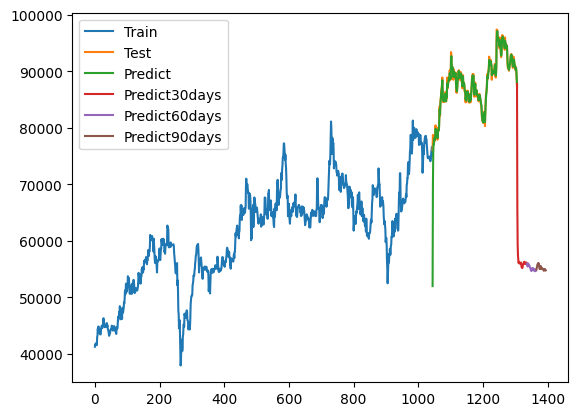

In [107]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,test_predicted)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[60:90]))
plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days', 'Predict90days'])
plt.show()



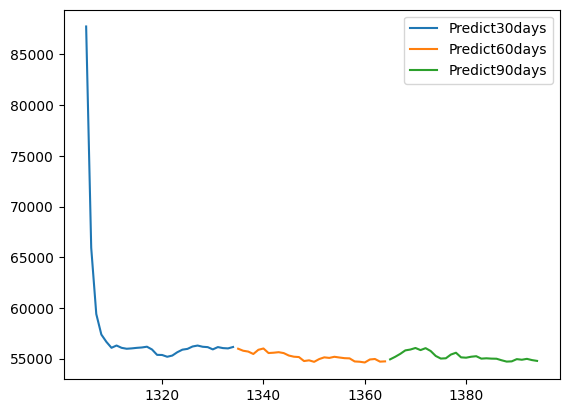

In [108]:


prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[60:90]))

plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.show()